# Imports

In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_regression

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor




In [2]:
def gini_impurity(column):
    impurity = 1
    counters = Counter(column)
    for value in column.unique():
        impurity -= (counters[value] / len(column)) ** 2

    return impurity

# Read Data

In [50]:
data = pd.read_csv('features.csv')
# Delete unesessary features from dataset
data = data.dropna()
data = data.drop(['enterworld_num','buyitemnowmainauction_num','completechallengeweek_num'],axis=1)
data = data.drop(['actor_account_id','survival_time'],axis=1)
data = data.drop(columns=data.columns[0],axis=1)
# Setup & split dataset for training
X = data.copy()
y = X.pop('churn_yn')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)
# Print training data shape
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)
# Get feature names from training set
feature_names = [f"feature {i}" for i in range(X.shape[1])]

(995, 33) (995,)
(2985, 33) (2985,)


# Build desicion tree

In [12]:
clf = DecisionTreeClassifier(criterion='gini', 
    splitter='best', 
    max_depth=4, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=20, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None, 
    ccp_alpha=0.0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)


## Get scores from tree

In [13]:
#F1-score
print("F1 Score")
print('f1 ' , f1_score(y_test, predictions))
#Cross validation
scores = cross_val_score(clf, X, y, cv=5)
print("CrossValidation Scores: ")
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

F1 Score
f1  0.5901639344262295
CrossValidation Scores: 
[0.77889447 0.7638191  0.75879397 0.74874372 0.75753769]
0.76 accuracy with a standard deviation of 0.01


[Text(0.5, 0.9, 'X[18] <= 45.5\ngini = 0.419\nsamples = 2985\nvalue = [2093, 892]'),
 Text(0.25, 0.7, 'X[19] <= 17439903.0\ngini = 0.473\nsamples = 764\nvalue = [294, 470]'),
 Text(0.125, 0.5, 'X[26] <= 1894.085\ngini = 0.428\nsamples = 499\nvalue = [155, 344]'),
 Text(0.0625, 0.3, 'X[32] <= 504.0\ngini = 0.301\nsamples = 146\nvalue = [27, 119]'),
 Text(0.03125, 0.1, 'gini = 0.153\nsamples = 60\nvalue = [5, 55]'),
 Text(0.09375, 0.1, 'gini = 0.381\nsamples = 86\nvalue = [22, 64]'),
 Text(0.1875, 0.3, 'X[14] <= 605531.844\ngini = 0.462\nsamples = 353\nvalue = [128, 225]'),
 Text(0.15625, 0.1, 'gini = 0.408\nsamples = 200\nvalue = [57, 143]'),
 Text(0.21875, 0.1, 'gini = 0.497\nsamples = 153\nvalue = [71, 82]'),
 Text(0.375, 0.5, 'X[26] <= 117768.871\ngini = 0.499\nsamples = 265\nvalue = [139, 126]'),
 Text(0.3125, 0.3, 'X[18] <= 30.5\ngini = 0.481\nsamples = 107\nvalue = [43, 64]'),
 Text(0.28125, 0.1, 'gini = 0.456\nsamples = 94\nvalue = [33, 61]'),
 Text(0.34375, 0.1, 'gini = 0.355\ns

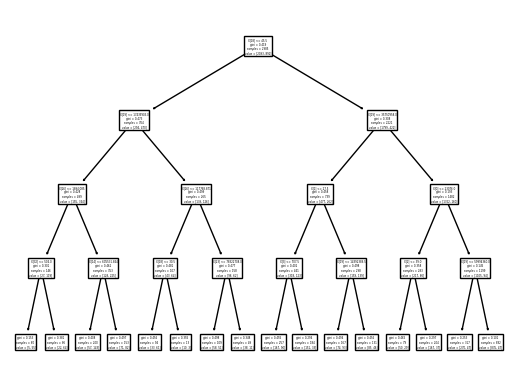

In [14]:
tree.plot_tree(clf)

# Feature importance decision tree

In [15]:
d_tree = clf
d_importances = d_tree.feature_importances_


<AxesSubplot: title={'center': 'Feature importances using MDI'}, ylabel='Mean decrease in impurity'>

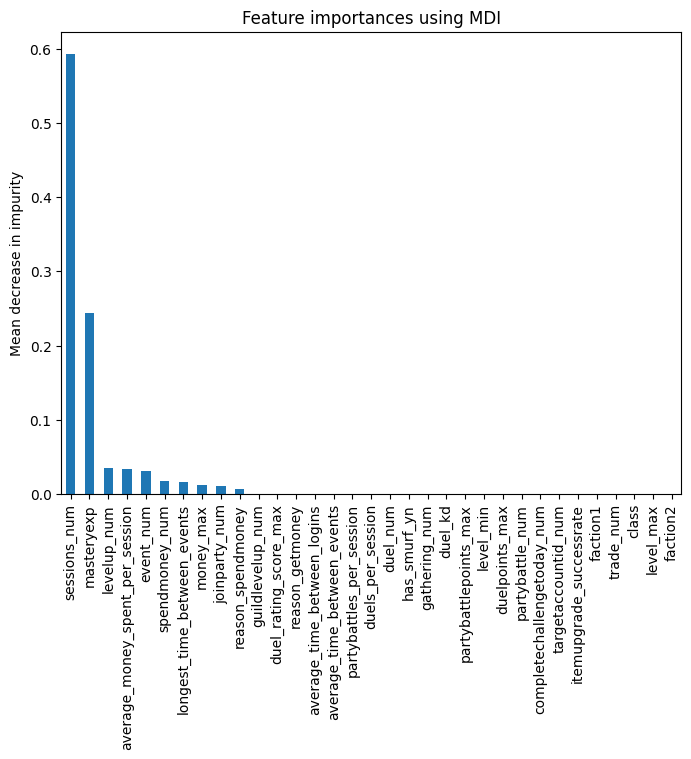

In [16]:
d_tree_importances = pd.Series(d_importances, index=feature_names)
fig, ax = plt.subplots()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
d_tree_feat_importances = pd.DataFrame(d_tree.feature_importances_, index=d_tree.feature_names_in_, columns=["Importance"])
d_tree_feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
d_tree_feat_importances['Importance'].plot(kind='bar', figsize=(8,6), ax=ax)

In [34]:
print("Top 10 features:")
d_tree_feat_importances.iloc[:10]

Top 10 features:


,Importance
sessions_num,0.593544
masteryexp,0.244250
levelup_num,0.035433
average_money_spent_per_session,0.033770
event_num,0.031092
spendmoney_num,0.017733
longest_time_between_events,0.015746
money_max,0.011346
joinparty_num,0.011128
reason_spendmoney,0.005957


## permutated

In [35]:
d_tree_result = permutation_importance(
    d_tree, X_test, y_test, n_repeats=10, random_state=100, n_jobs=2)

<AxesSubplot: title={'center': 'Feature importances using permutation on full model'}, ylabel='Mean accuracy decrease'>

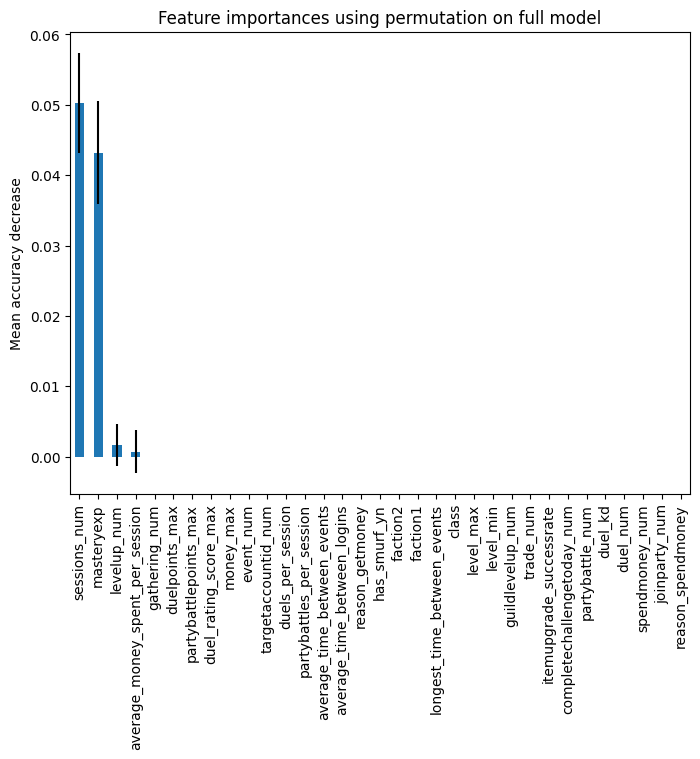

In [39]:
fig, ax = plt.subplots()
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
d_tree_feat_importances_p = pd.DataFrame(d_tree_result.importances_mean, index=d_tree.feature_names_in_, columns=["Importance"])
d_tree_feat_importances_p['errors']=d_tree_result.importances_std
d_tree_feat_importances_p.sort_values(by='Importance', ascending=False, inplace=True)
d_tree_feat_importances_p['Importance'].plot(kind='bar', figsize=(8,6), ax=ax, yerr=d_tree_feat_importances_p['errors'])

In [41]:
print("Top 10 features:")
d_tree_feat_importances_p.iloc[:10]

Top 10 features:


,Importance,errors
sessions_num,0.050251,0.007149
masteryexp,0.043216,0.007344
levelup_num,0.001608,0.002954
average_money_spent_per_session,0.000704,0.003017
gathering_num,0.000000,0.000000
duelpoints_max,0.000000,0.000000
partybattlepoints_max,0.000000,0.000000
duel_rating_score_max,0.000000,0.000000
money_max,0.000000,0.000000
event_num,0.000000,0.000000


# Feature Importance Random Forest

In [26]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)

In [27]:
#F1-score
print("F1 Score")
print('f1 ' , f1_score(y_test, predictions))
#Cross validation
scores = cross_val_score(forest, X, y, cv=5)
print("CrossValidation Scores: ")
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

F1 Score
f1  0.5386138613861386
CrossValidation Scores: 
[0.78140704 0.75376884 0.79773869 0.75753769 0.77889447]
0.77 accuracy with a standard deviation of 0.02


In [28]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

<AxesSubplot: title={'center': 'Feature importances using MDI'}, ylabel='Mean decrease in impurity'>

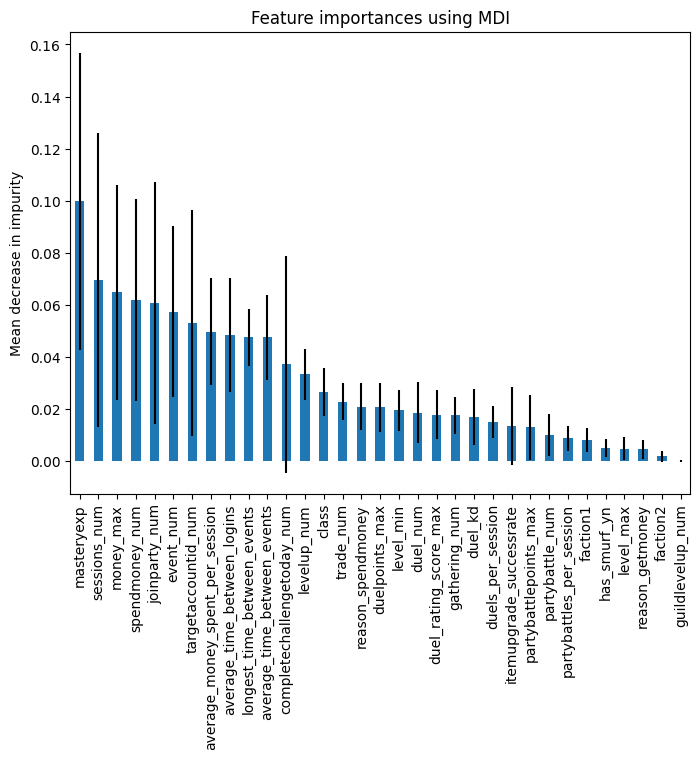

In [29]:
#forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
feat_importances = pd.DataFrame(forest.feature_importances_, index=forest.feature_names_in_, columns=["Importance"])
feat_importances['errors']=std
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances['Importance'].plot(kind='bar', figsize=(8,6), ax=ax, yerr=feat_importances['errors'])

In [30]:
print("Top 10 features:")
feat_importances.iloc[:10]

Top 10 features:


,Importance,errors
masteryexp,0.099861,0.056962
sessions_num,0.069516,0.056382
money_max,0.064951,0.041297
spendmoney_num,0.062046,0.038776
joinparty_num,0.060751,0.046503
event_num,0.057442,0.032895
targetaccountid_num,0.053098,0.043445
average_money_spent_per_session,0.049706,0.020516
average_time_between_logins,0.048536,0.021774
longest_time_between_events,0.047652,0.010926


In [31]:
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=100, n_jobs=2)

<AxesSubplot: title={'center': 'Feature importances using permutation on full model'}, ylabel='Mean accuracy decrease'>

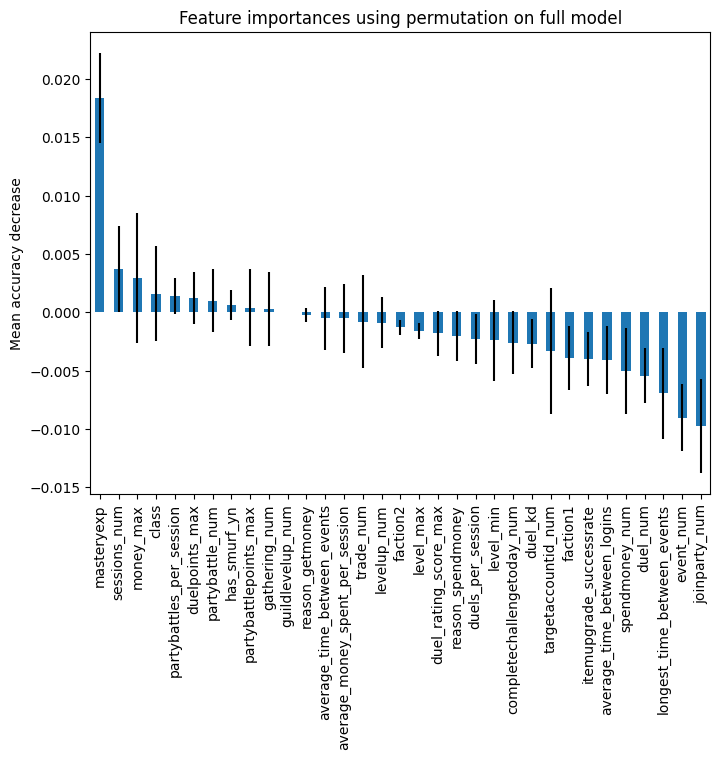

In [32]:
fig, ax = plt.subplots()
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
feat_importances_p = pd.DataFrame(result.importances_mean, index=forest.feature_names_in_, columns=["Importance"])
feat_importances_p['errors']=result.importances_std
feat_importances_p.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances_p['Importance'].plot(kind='bar', figsize=(8,6), ax=ax, yerr=feat_importances_p['errors'])

In [33]:
print("Top 10 features:")
feat_importances_p.iloc[:10]

Top 10 features:


,Importance,errors
masteryexp,0.018392,0.003868
sessions_num,0.003719,0.003680
money_max,0.002915,0.005586
class,0.001608,0.004050
partybattles_per_session,0.001407,0.001570
duelpoints_max,0.001206,0.002238
partybattle_num,0.001005,0.002697
has_smurf_yn,0.000603,0.001287
partybattlepoints_max,0.000402,0.003309
gathering_num,0.000302,0.003180


# XGB Regressor

In [56]:
xgboost = XGBRegressor()
xgboost.fit(X,y)
predictions = xgboost.predict(X_test)

In [58]:
#F1-score
#print("F1 Score")
#print('f1 ' , f1_score(y_test, predictions))

#Cross validation
scores = cross_val_score(xgboost, X, y, cv=5)
print("CrossValidation Scores: ")
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

CrossValidation Scores: 
[0.18098344 0.08582461 0.1889753  0.05860793 0.10125084]
0.12 accuracy with a standard deviation of 0.05


<AxesSubplot: title={'center': 'Feature importances using MDI'}, ylabel='Mean decrease in impurity'>

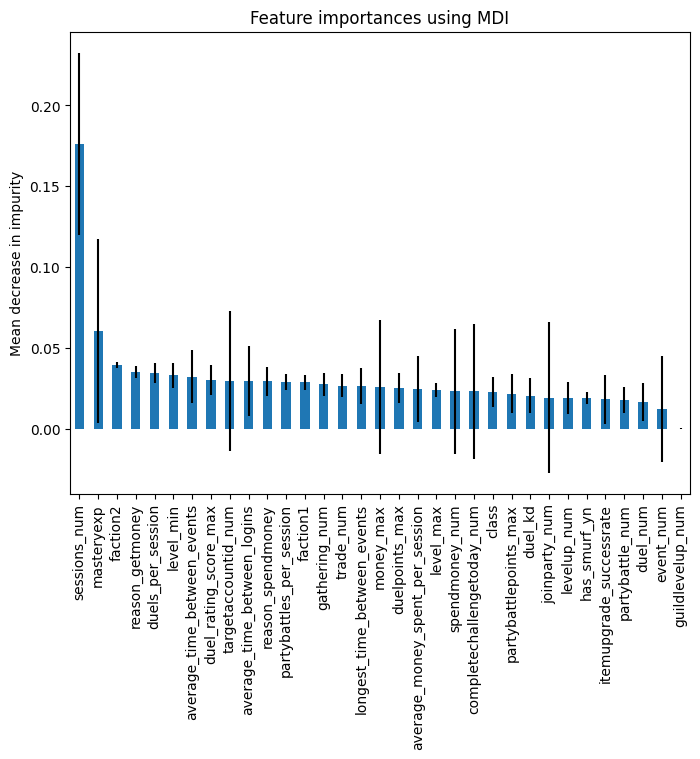

In [52]:
fig, ax = plt.subplots()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
feat_importances = pd.DataFrame(xgboost.feature_importances_, index=xgboost.feature_names_in_, columns=["Importance"])
feat_importances['errors']=std
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances['Importance'].plot(kind='bar', figsize=(8,6), ax=ax, yerr=feat_importances['errors'])

In [53]:
result = permutation_importance(
    xgboost, X_test, y_test, n_repeats=10, random_state=100, n_jobs=2)

<AxesSubplot: title={'center': 'Feature importances using permutation on full model'}, ylabel='Mean accuracy decrease'>

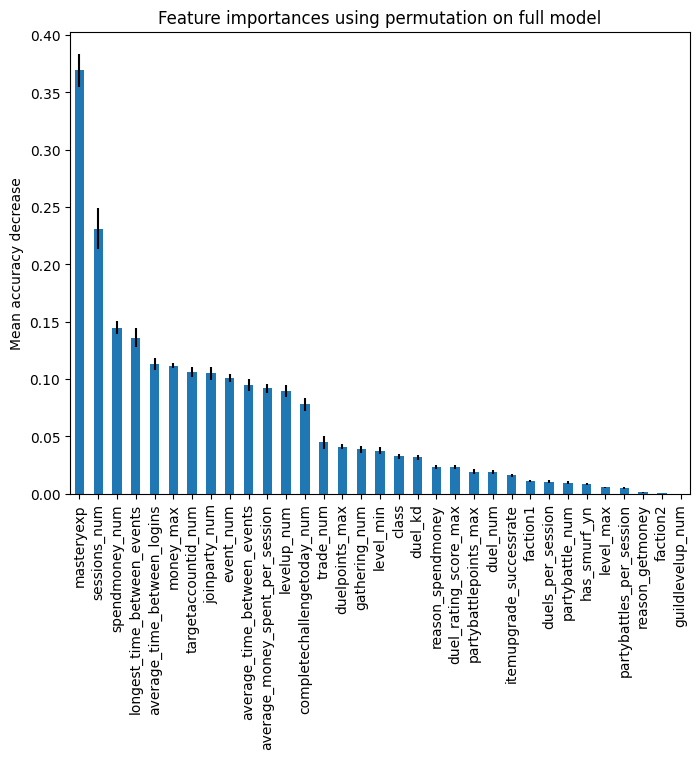

In [54]:
fig, ax = plt.subplots()
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
feat_importances_p = pd.DataFrame(result.importances_mean, index=xgboost.feature_names_in_, columns=["Importance"])
feat_importances_p['errors']=result.importances_std
feat_importances_p.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances_p['Importance'].plot(kind='bar', figsize=(8,6), ax=ax, yerr=feat_importances_p['errors'])

In [60]:
print("Top 10 features:")
feat_importances_p.iloc[:10]

Top 10 features:


,Importance,errors
masteryexp,0.369189,0.014573
sessions_num,0.231279,0.017642
spendmoney_num,0.144932,0.005819
longest_time_between_events,0.136269,0.008022
average_time_between_logins,0.113093,0.005569
money_max,0.111576,0.002228
targetaccountid_num,0.106038,0.004178
joinparty_num,0.105129,0.005612
event_num,0.101143,0.003716
average_time_between_events,0.094516,0.005180
